# task definition
Train a model to classify a movie rewiew in positive or negative polarity.

# data collection
dataset of IMDb, available at: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

it uses 'wget' python module. Use ```pip install wget``` to install it!


In [18]:
import wget
import os
import tarfile
import numpy

numpy.random.seed(42)

filename = "dataset/aclImdb_v1.tar.gz"

dataset_link = "http://ai.stanford.edu/~amaas/data/sentiment/{}".format("aclImdb_v1.tar.gz")
try:
    os.mkdir("dataset")
except OSError:
    pass

if not os.path.isfile(filename):
    file = wget.download(dataset_link, out='dataset/aclImdb_v1.tar.gz')

    tar = tarfile.open(filename, "r:gz")
    tar.extractall("dataset")
    tar.close()

# data load and visualization

In [19]:
# montar dataset com valores de 1 a 4 e de 7 a 10, ao invés de binário
dataset_path = 'dataset/aclImdb'
train_positive_files = ['train/pos/'+f for f in os.listdir(dataset_path+'/train/pos') \
                        if os.path.isfile(os.path.join(dataset_path+'/train/pos', f))]

train_negative_files = ['train/neg/'+f for f in os.listdir(dataset_path+'/train/neg') \
                        if os.path.isfile(os.path.join(dataset_path+'/train/neg', f))]

test_positive_files = ['test/pos/'+f for f in os.listdir(dataset_path+'/test/pos') \
                       if os.path.isfile(os.path.join(dataset_path+'/test/pos', f))]

test_negative_files = ['test/neg/'+f for f in os.listdir(dataset_path+'/test/neg') \
                       if os.path.isfile(os.path.join(dataset_path+'/test/neg', f))]

all_files = list(set().union(train_positive_files,train_negative_files, test_positive_files, test_negative_files))

In [20]:
dataset = {'trainset':[], 
           'polarity':[], 
           'bin_polarity': [],
           'review':[]}

for file in all_files:
    polarity = file.split('.')[0].split('_')[1]
    with open(os.path.join(dataset_path, file), 'r') as text_file:
        dataset['trainset'].append(file.split('/')[0])
        bin_polarity = 1 if int(polarity) > 5 else 0  # transform into binary polarity
        dataset['bin_polarity'].append(bin_polarity)
        dataset['polarity'].append(polarity)
        dataset['review'].append(text_file.readlines()[0])

In [21]:
import pandas as pd
dataframe = pd.DataFrame(data=dataset)

In [22]:
dataframe.head()

,trainset,polarity,bin_polarity,review
0,test,7,1,Reasonably effective horror/science-fiction a ...
1,train,8,1,"This cartoon is short on plot, but is a visual..."
2,test,4,0,"Okay, you have:<br /><br />Penelope Keith as M..."
3,train,3,0,"In the third entry of the Phantasm series, Mik..."
4,train,3,0,"Where to start? OK, don't compare this film to..."


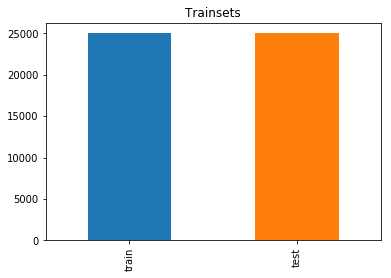

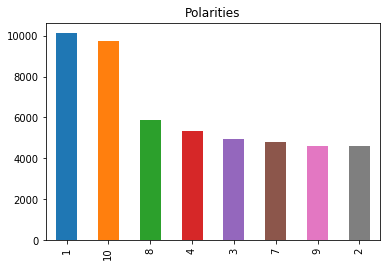

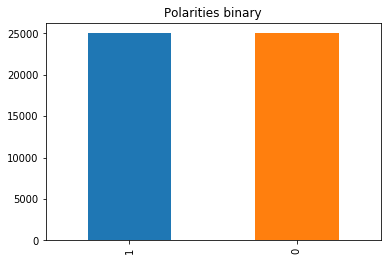

In [23]:
import matplotlib.pyplot as plt

dataframe['trainset'].value_counts().plot(kind='bar',title='Trainsets')
plt.show()

dataframe['polarity'].value_counts().plot(kind='bar',title='Polarities')
plt.show()

dataframe['bin_polarity'].value_counts().plot(kind='bar',title='Polarities binary')
plt.show()

# pre processing

In [24]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)
    
    return review

dataframe['clean_review'] = dataframe['review'].apply(preprocess_reviews)

In [25]:
dataframe.head()

,trainset,polarity,bin_polarity,review,clean_review
0,test,7,1,Reasonably effective horror/science-fiction a ...,reasonably effective horror science fiction a ...
1,train,8,1,"This cartoon is short on plot, but is a visual...",this cartoon is short on plot but is a visuall...
2,test,4,0,"Okay, you have:<br /><br />Penelope Keith as M...",okay you have penelope keith as miss herringbo...
3,train,3,0,"In the third entry of the Phantasm series, Mik...",in the third entry of the phantasm series mike...
4,train,3,0,"Where to start? OK, don't compare this film to...",where to start ok dont compare this film to fi...


# feature engineering

In [26]:
train_reviews = dataframe[dataframe['trainset'] == 'train']['clean_review'].values.tolist()
train_classes = dataframe[dataframe['trainset'] == 'train']['bin_polarity'].values.tolist()
test_reviews = dataframe[dataframe['trainset'] == 'test']['clean_review'].values.tolist()
test_classes = dataframe[dataframe['trainset'] == 'test']['bin_polarity'].values.tolist()

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

cv = CountVectorizer(binary=True)
cv.fit(train_reviews)
X = cv.transform(train_reviews)
X_test = cv.transform(test_reviews)

In [28]:
#save cv model
try:
    os.mkdir("models")
except OSError:
    pass

s = pickle.dumps(cv)
with open('models/cv_pickle', 'wb') as pickle_file:
    pickle_file.write(s)

# Training

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, train_classes, train_size = 0.75
)

In [30]:
for c in [0.001, 0.005, 0.009, 0.01, 0.015, 0.02, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    

Accuracy for C=0.001: 0.84272
Accuracy for C=0.005: 0.86432
Accuracy for C=0.009: 0.87088
Accuracy for C=0.01: 0.87168
Accuracy for C=0.015: 0.87584
Accuracy for C=0.02: 0.87616
Accuracy for C=1: 0.87472


In [31]:
final_model = LogisticRegression(C=0.02)
final_model.fit(X, train_classes)
print ("Final Accuracy: %s" 
       % accuracy_score(test_classes, final_model.predict(X_test)))

Final Accuracy: 0.88116


In [32]:
s = pickle.dumps(final_model)
with open('models/final_model', 'wb') as pickle_file:
    pickle_file.write(s)

# evaluation

In [33]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
        
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('excellent', 0.7700114234286476)
('perfect', 0.643803750600919)
('great', 0.6257844426344494)
('amazing', 0.5128833135754599)
('wonderful', 0.5041675571876316)
('worst', -1.1322335000066437)
('waste', -0.8909313898755431)
('awful', -0.8264980442866634)
('boring', -0.6949303901440904)
('bad', -0.6472233520501927)


# deploying
install flask using ```pip3 install flask```. Let's create a REST service to make it available!
The following code must be put in a python file ```app.py```. 

In the same directory of the previous file, run the commands bellow:

```chmod a+x app.py```

```python3 app.py```

In [ ]:
from flask import Flask, request
from sklearn.feature_extraction.text import CountVectorizer
import re
import pickle

# regular expressions
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# load vectorization model
pickle_file = open('models/cv_pickle', 'rb')
cv = pickle.loads(pickle_file.read())

# load ML model
pickle_file = open('models/final_model', 'rb')
final_model = pickle.loads(pickle_file.read())


# prepare input to be classified
def prepare_input(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)

    return cv.transform([review])


app = Flask(__name__)

@app.route('/api/v1.0/scorefy', methods=["GET"])
def scorefy():
    query_parameters = request.args
    review = query_parameters.get('r')
    return final_model.predict(prepare_input(review))[0]


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=3000, debug=True)
